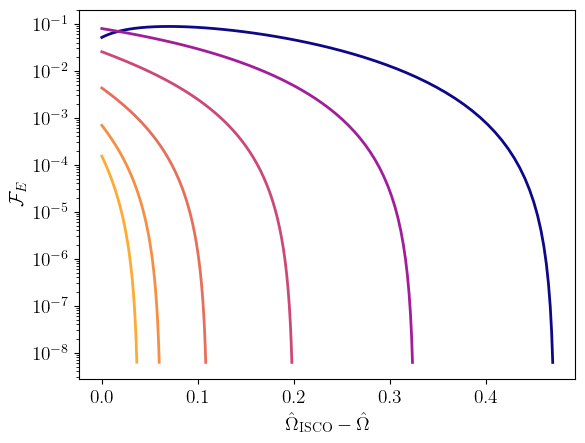

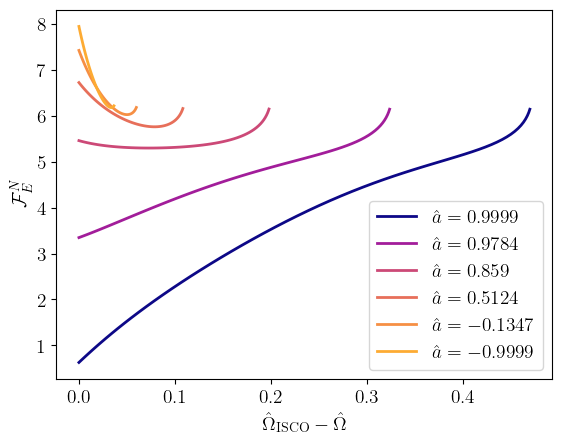

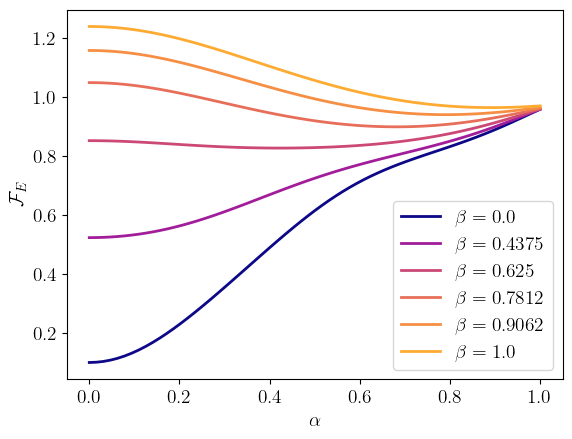

In [16]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 14})

import os
# pathname = os.path.dirname(os.path.abspath(__file__))

OMEGA_MIN = 2.e-3
A_MAX = 0.9999

def alpha_of_a_omega(a, omega):
    oISCO = kerr_isco_frequency(a)
    return alpha_of_omega_ISCO(omega, oISCO)

def alpha_of_omega_ISCO(omega, oISCO):
    return (abs(oISCO**(1./3.) - omega**(1./3.))/(oISCO**(1./3.) - OMEGA_MIN**(1./3.)))**(0.5)

def omega_of_a_alpha(a, alpha):
    oISCO = kerr_isco_frequency(a)
    return omega_of_alpha_ISCO(alpha, oISCO)

def omega_of_alpha_ISCO(alpha, oISCO):
    return pow(pow(oISCO, 1./3.) - pow(alpha, 2.)*(pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.)), 3.)

def chi_of_spin_subfunc(a):
    return pow(1. - a, 1./3.)

def chi_of_spin(a):
    return pow((chi_of_spin_subfunc(a) - chi_of_spin_subfunc(A_MAX))/(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 0.5)

def spin_of_chi(chi):
    return 1. - pow(chi_of_spin_subfunc(A_MAX) + pow(chi, 2.)*(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 3.)

def a_omega_to_chi_alpha(a, omega):
    chi = chi_of_spin(a)
    alpha = alpha_of_a_omega(a, omega)
    return (chi, alpha)

traj = np.loadtxt("../data/trajectory.txt", skiprows=3)
trajHeader = np.loadtxt("../data/trajectory.txt", skiprows=2, max_rows=1, dtype='str')
trajShape = np.loadtxt("../data/trajectory.txt", skiprows=1, max_rows=1, dtype='int')

phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape))
timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape))
fluxData = np.ascontiguousarray(traj[:, 2].reshape(trajShape))
betaData = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])
alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])

Edot = BicubicSpline(betaData, alphaData, fluxData)
PhiCheck = BicubicSpline(betaData, alphaData, phaseData)
TCheck = BicubicSpline(betaData, alphaData, timeData)

downsample_rate = 4
Nb = int((betaData.shape[0] - 1)/downsample_rate + 1)
Na = int((alphaData.shape[0] - 1)/downsample_rate + 1)
flux_samples = np.zeros((Nb, Na, 5))
phase_samples = np.zeros((Nb, Na, 5))
time_samples = np.zeros((Nb, Na, 5))
for i in range(Nb):
    for j in range(Na):
        beta = betaData[downsample_rate*i]
        alpha = alphaData[downsample_rate*j]
        atemp = spin_of_chi(beta)
        otemp = omega_of_a_alpha(atemp, alpha)
        EdotData = Edot(beta, alpha)
        PData = PhiCheck(beta, alpha)
        TData = TCheck(beta, alpha)
        flux_samples[i, j] = [atemp, otemp, EdotData, alpha, beta]
        phase_samples[i, j] = [atemp, otemp, PData, alpha, beta]
        time_samples[i, j] = [atemp, otemp, TData, alpha, beta]

cmap_temp = mpl.colormaps['plasma'].resampled(80)
alist = [0, 14, 20, 25, 29, 32]

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E^N$')
plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, betas = flux_samples[i,:,3:].T
    plt.plot(alphas, EdotVals, label="$\\beta = {:.4}$".format(betas[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$\mathcal{F}_E$')
plt.legend()
plt.show()

# for i in [0, 10, 14, 22, 26, 30, 32]: 
#     avals, omegas, EdotVals = flux_samples[i].T
#     EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
#     plt.plot(omegas, EdotVals_reweighted, label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('$\hat{\Omega}$')
# plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
# plt.savefig(pathname+"/../figures/trajectory_a_omega.pdf", bbox_inches="tight", dpi=300)

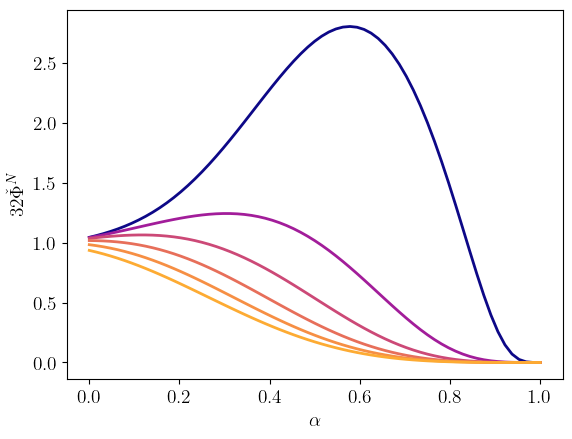

In [21]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    Pvals_shifted = 32*(PVals)*omegas**(5/3)
    alphas, betas = flux_samples[i,:,3:].T
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
    avals, omegas, TVals = time_samples[i,:,:3].T
    Tvals_shifted = 256/5*TVals*(omegas)**(8/3)
    # plt.plot(alphas, np.flip(Tvals_shifted), '--', color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

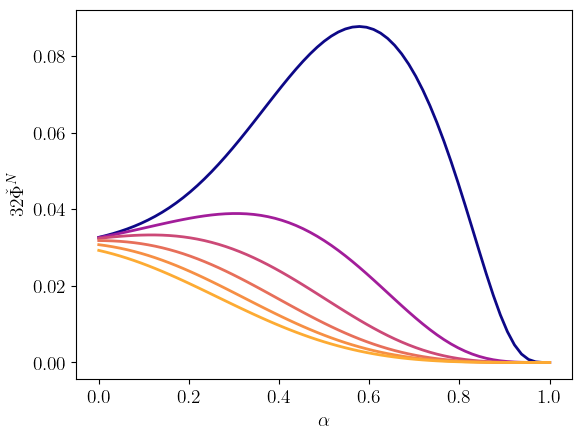

In [58]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    alphas, betas = flux_samples[i,:,3:].T
    Pvals_shifted = PVals*omegas**(5/3)
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

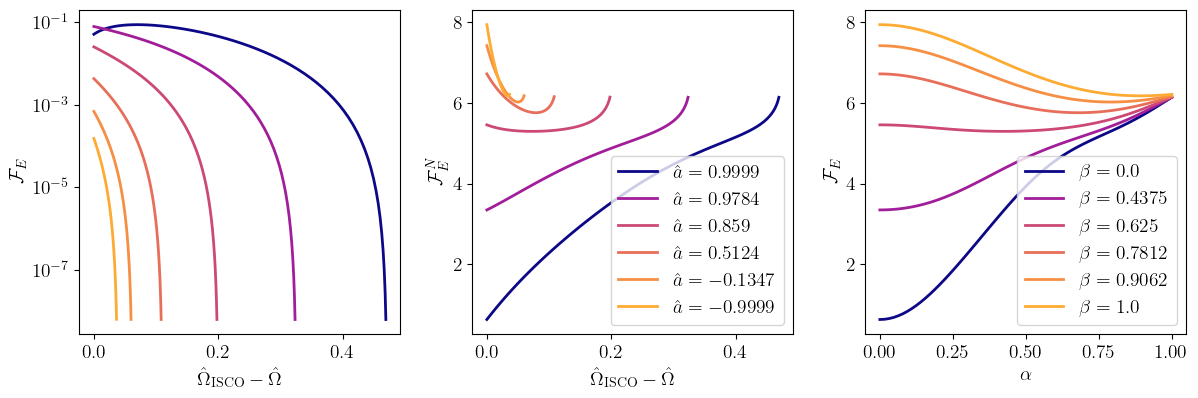

In [69]:
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    axs[0].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    axs[1].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
axs[1].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, betas = flux_samples[i,:,3:].T
    axs[2].plot(alphas, 32./5.*EdotVals, label="$\\beta = {:.4}$".format(betas[0]), color=cmap_temp(2*i), lw=2)
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()